<a href="https://colab.research.google.com/github/seongwoojang1123/TMJ-osteoarthritis-diagnosis-/blob/main/5_TMJ_OA_CBCT_MRI_Traning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
import os
import cv2
import pickle
import numpy as np
import tensorflow as tf
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import random
from tqdm import tqdm
from tensorflow.keras.initializers import GlorotUniform
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report, roc_auc_score, accuracy_score
from tensorflow.keras.models import load_model
from tensorflow.keras.metrics import AUC

Prepare Dataset

In [11]:
# 폴더 경로
base_dir = "/content/drive/MyDrive/TMJ OA/기존 CBCT 1,3 + NEW CBCT 1,2"
stages = ['train_data', 'validation_data', 'test_data']
folders = ['Lt_Normal', 'Lt_OA', 'Rt_Normal', 'Rt_OA']
label_mapping = {
    'Lt_Normal': 0,
    'Lt_OA': 1,
    'Rt_Normal': 0,
    'Rt_OA': 1
}

# 데이터를 저장할 딕셔너리
data = {}

for stage in stages:
    print(f"Processing {stage}...")
    data[stage] = {'image': [], 'patient_id': [], 'side': [], 'label': []}

    stage_path = os.path.join(base_dir, stage)
    for folder in folders:
        folder_path = os.path.join(stage_path, folder)
        label = label_mapping[folder]  # 폴더 이름으로 Label 결정

        for image_file in tqdm(os.listdir(folder_path)):
            if not image_file.lower().endswith('.jpg'):
                continue  # 이미지 파일이 아니면 스킵

            try:
                # 파일 이름에서 Patient ID 추출
                name, ext = os.path.splitext(image_file) # CBCT Code
                parts = name.split(' ')
                patient_id = parts[0]

                #patient_id, side = image_file.split('') # MRI CODE
                side = 'Lt' if 'Lt' in folder else 'Rt'  # 폴더 이름에서 좌우 구분
                image_path = os.path.join(folder_path, image_file)

                # 이미지 읽고 리사이즈
                image = cv2.imread(image_path)
                resized_image = cv2.resize(image, (140, 140))  # 리사이즈 크기 설정
                data[stage]['image'].append(resized_image)
                data[stage]['patient_id'].append(patient_id)
                data[stage]['side'].append(side)
                data[stage]['label'].append(label)

            except Exception as e:
                print(f"Error processing file: {image_file}, Error: {e}")

    # numpy 배열로 변환
    data[stage]['image'] = np.array(data[stage]['image'])
    data[stage]['label'] = np.array(data[stage]['label'])

# 데이터 저장
pkl_file_path = os.path.join(base_dir, "/content/drive/MyDrive/TMJ OA/기존 CBCT 1,3 + NEW CBCT 1,2/tmj_oa_CBCT1,3 + NEW_dataset_555.pkl")
with open(pkl_file_path, 'wb') as f:
    pickle.dump(data, f)

print(f"Data successfully saved to {pkl_file_path}")

Processing train_data...


100%|██████████| 316/316 [00:06<00:00, 47.28it/s] 


Processing validation_data...


100%|██████████| 102/102 [00:02<00:00, 36.01it/s] 


Processing test_data...


100%|██████████| 111/111 [00:02<00:00, 39.22it/s]


Data successfully saved to /content/drive/MyDrive/TMJ OA/기존 CBCT 1,3 + NEW CBCT 1,2/tmj_oa_CBCT1,3 + NEW_dataset_555.pkl


In [12]:
with open(pkl_file_path, 'rb') as f:
    loaded_data = pickle.load(f)

for stage in stages:
    print(f"Stage: {stage}")    print(f"Number of Images: {len(loaded_data[stage]['image'])}")
    print(f"Patient IDs: {loaded_data[stage]['patient_id'][:5]}")
    print(f"Sides: {loaded_data[stage]['side'][:5]}")
    print(f"Labels: {loaded_data[stage]['label'][:5]}")
    print("-" * 30)

Stage: train_data
Number of Images: 1645
Patient IDs: ['11053022', '14957701', '11858325', '11981447', '14966086']
Sides: ['Lt', 'Lt', 'Lt', 'Lt', 'Lt']
Labels: [0 0 0 0 0]
------------------------------
Stage: validation_data
Number of Images: 550
Patient IDs: ['11177143', '11660540', '14988707', '14951489', '10664250']
Sides: ['Lt', 'Lt', 'Lt', 'Lt', 'Lt']
Labels: [0 0 0 0 0]
------------------------------
Stage: test_data
Number of Images: 550
Patient IDs: ['14003185', '12725494', '14976260', '11880794', '15024738']
Sides: ['Lt', 'Lt', 'Lt', 'Lt', 'Lt']
Labels: [0 0 0 0 0]
------------------------------


Traning

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
Class weights: {0: 0.8923303834808259, 1: 1.137218045112782}
Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


19/19 ━━━━━━━━━━━━━━━━━━━━ 108s 3s/step - accuracy: 0.5115 - auc: 0.5258 - loss: 0.8214 - val_accuracy: 0.4395 - val_auc: 0.5956 - val_loss: 0.7813 - learning_rate: 1.0000e-04
Epoch 2/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 53s 615ms/step - accuracy: 0.5278 - auc: 0.5313 - loss: 0.7569 - val_accuracy: 0.5605 - val_auc: 0.6096 - val_loss: 0.8706 - learning_rate: 1.0000e-04
Epoch 3/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 13s 562ms/step - accuracy: 0.5485 - auc: 0.5667 - loss: 0.7379 - val_accuracy: 0.4395 - val_auc: 0.5841 - val_loss: 1.6564 - learning_rate: 1.0000e-04
Epoch 4/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 12s 526ms/step - accuracy: 0.5268 - auc: 0.5559 - loss: 0.7100 - val_accuracy: 0.5605 - val_auc: 0.5723 - val_loss: 1.8606 - learning_rate: 1.0000e-04
Epoch 5/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 22s 501ms/step - accuracy: 0.5533 - auc: 0.6025 - loss: 0.6971 - val_accuracy: 0.4395 - val_auc: 0.5000 - val_loss: 14.1066 - learning_rate: 1.0000e-04
Epoch 6/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 19s 516ms/step - accuracy: 0.

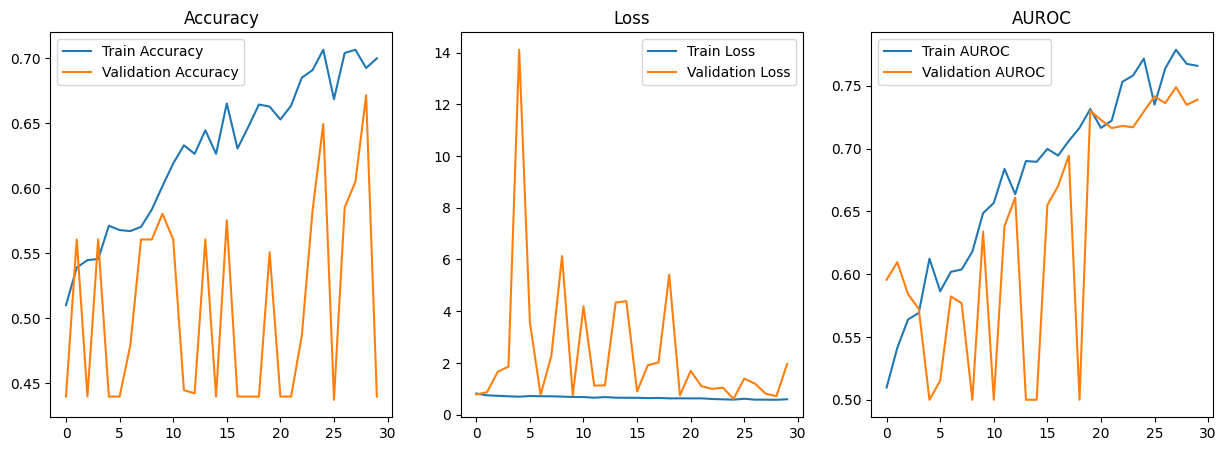

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 102ms/step - accuracy: 0.6802 - auc: 0.6046 - loss: 0.6758
Test Loss: 0.8339, Test Accuracy: 0.5901, Test AUROC: 0.7098
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 181ms/step
Optimal Threshold: 0.1668


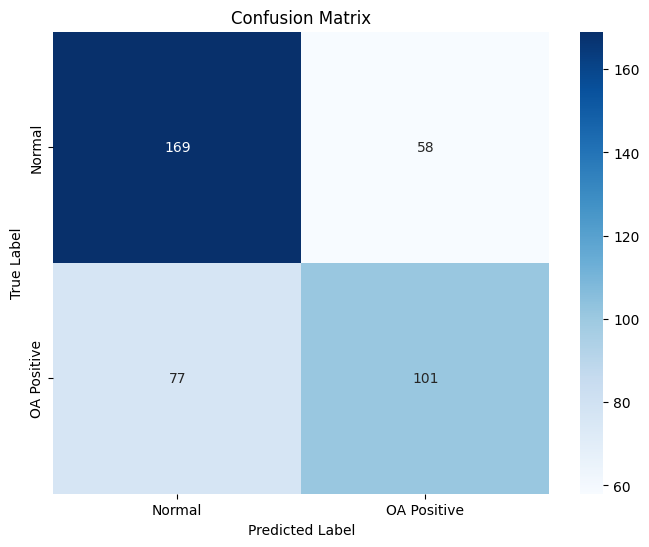

Confusion Matrix:
 [[169  58]
 [ 77 101]]
Classification Report:
               precision    recall  f1-score   support

           0       0.69      0.74      0.71       227
           1       0.64      0.57      0.60       178

    accuracy                           0.67       405
   macro avg       0.66      0.66      0.66       405
weighted avg       0.66      0.67      0.66       405



In [ ]:
# 랜덤 시드 설정
seed = 42  # 고정된 랜덤 시드 값
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)

# 피클 파일 로드
with open('/content/drive/MyDrive/TMJ OA/학습_data_1,3(crop)/tmj_oa_CBCT1,3_dataset555.pkl', 'rb') as f:
    dataset = pickle.load(f)

# 데이터셋 분리
train_images = dataset['train_data']['image']
train_labels = dataset['train_data']['label']
val_images = dataset['validation_data']['image']
val_labels = dataset['validation_data']['label']
test_images = dataset['test_data']['image']
test_labels = dataset['test_data']['label']

# 데이터 증강 생성기 설정
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],
    fill_mode='reflect'
)

val_datagen = ImageDataGenerator(rescale=1.0 / 255)
test_datagen = ImageDataGenerator(rescale=1.0 / 255)

# 데이터 증강 생성기를 통해 데이터 생성
train_generator = train_datagen.flow(
    train_images, train_labels, batch_size=64, shuffle=True, seed=seed
)

val_generator = val_datagen.flow(
    val_images, val_labels, batch_size=64, shuffle=False, seed=seed
)

test_generator = test_datagen.flow(
    test_images, test_labels, batch_size=64, shuffle=False, seed=seed
)

# VGG16 모델 구성
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(140, 140, 3))
for layer in base_model.layers[:-12]:
    layer.trainable = True
    layer.kernel_initializer = GlorotUniform(seed=seed)

model = Sequential([
    base_model,
    Flatten(),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

# 모델 컴파일
optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy', tf.keras.metrics.AUC(name='auc')])

# 클래스 가중치 계산
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_labels),
    y=train_labels
)

class_weights = dict(enumerate(class_weights))
#class_weights = {0: 0.8576642335766423, 1: 1.1989795918367347}  # 클래스 1에 더 높은 가중치 부여
print("Class weights:", class_weights)


# 콜백 설정
early_stopping = EarlyStopping(monitor='val_auc', patience=10, mode='max', restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model_vgg16_auroc.keras', save_best_only=True, monitor='val_auc', mode='max')
reduce_lr = ReduceLROnPlateau(monitor='val_auc', factor=0.5, patience=7, mode='max', min_lr=1e-6)

# 모델 학습
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=30,
    class_weight=class_weights,
    callbacks=[early_stopping, model_checkpoint, reduce_lr]
)

# 학습 결과 시각화
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy')

plt.subplot(1, 3, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss')

plt.subplot(1, 3, 3)
plt.plot(history.history['auc'], label='Train AUROC')
plt.plot(history.history['val_auc'], label='Validation AUROC')
plt.legend()
plt.title('AUROC')
plt.show()

# 테스트 데이터 평가
test_loss, test_accuracy, test_auc = model.evaluate(test_generator)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}, Test AUROC: {test_auc:.4f}")

# ROC Curve
y_pred = model.predict(test_generator).flatten()
fpr, tpr, thresholds = roc_curve(test_labels, y_pred)
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print(f"Optimal Threshold: {optimal_threshold:.4f}")

# Confusion Matrix
y_pred_adjusted = (y_pred >= optimal_threshold).astype(int)
#y_pred_adjusted = (y_pred >= 0.4).astype(int)  # 임계값을 약간 높임
conf_matrix = confusion_matrix(test_labels, y_pred_adjusted)

# Confusion Matrix 시각화
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Normal", "OA Positive"], yticklabels=["Normal", "OA Positive"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", classification_report(test_labels, y_pred_adjusted))

model.save('/content/drive/MyDrive/TMJ OA/학습_data_1,3(crop)/CBCT1,3_model555.keras')

Assessment with figures

13/13 ━━━━━━━━━━━━━━━━━━━━ 9s 84ms/step
AUC: 0.7098
95% CI: 0.6608 - 0.7595


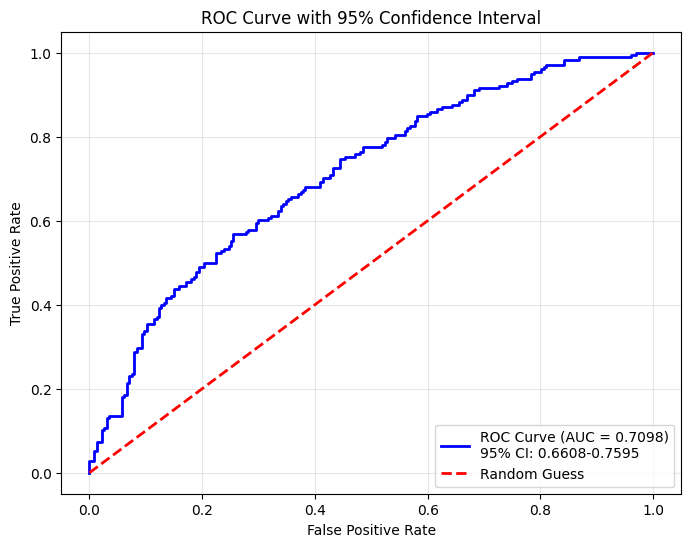

In [ ]:
# 테스트 레이블 및 예측값
y_true = test_labels  # 실제 레이블
y_pred = model.predict(test_images / 255.0).flatten()  # 예측 확률값 (스케일링된 이미지 사용)

# ROC Curve 계산
fpr, tpr, thresholds = roc_curve(y_true, y_pred)
roc_auc = roc_auc_score(y_true, y_pred)

# AUC 95% CI 계산 (부트스트랩)
n_bootstraps = 1000  # 부트스트랩 샘플 수
rng = np.random.RandomState(42)  # 재현성 확보
bootstrapped_aucs = []

for i in range(n_bootstraps):
    # 부트스트랩 샘플링
    indices = rng.choice(len(y_true), len(y_true), replace=True)
    y_true_bootstrap = y_true[indices]
    y_pred_bootstrap = y_pred[indices]

    try:
        auc_bootstrap = roc_auc_score(y_true_bootstrap, y_pred_bootstrap)
        bootstrapped_aucs.append(auc_bootstrap)
    except ValueError:  # 예외 처리 (불가능한 경우 스킵)
        continue

# 신뢰 구간 계산
lower = np.percentile(bootstrapped_aucs, 2.5)
upper = np.percentile(bootstrapped_aucs, 97.5)

print(f"AUC: {roc_auc:.4f}")
print(f"95% CI: {lower:.4f} - {upper:.4f}")

# ROC Curve 시각화
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (AUC = {roc_auc:.4f})\n95% CI: {lower:.4f}-{upper:.4f}')
plt.plot([0, 1], [0, 1], color='red', linestyle='--', lw=2, label='Random Guess')

# 그래프 스타일 설정
plt.title('ROC Curve with 95% Confidence Interval')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.show()

CBCT Find Tuning

Class Weights: {0: 1, 1: 1.5}
Epoch 1/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 22s 380ms/step - accuracy: 0.6100 - auc: 0.6456 - loss: 0.8748 - val_accuracy: 0.5605 - val_auc: 0.6318 - val_loss: 2.0845 - learning_rate: 1.0000e-04
Epoch 2/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 13s 265ms/step - accuracy: 0.6098 - auc: 0.6588 - loss: 0.8223 - val_accuracy: 0.5605 - val_auc: 0.7370 - val_loss: 1.9170 - learning_rate: 1.0000e-04
Epoch 3/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 10s 268ms/step - accuracy: 0.6418 - auc: 0.6989 - loss: 0.7951 - val_accuracy: 0.4395 - val_auc: 0.7453 - val_loss: 2.3059 - learning_rate: 1.0000e-04
Epoch 4/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 9s 247ms/step - accuracy: 0.6806 - auc: 0.7333 - loss: 0.7526 - val_accuracy: 0.5605 - val_auc: 0.5056 - val_loss: 3.4438 - learning_rate: 1.0000e-04
Epoch 5/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 11s 275ms/step - accuracy: 0.6564 - auc: 0.7404 - loss: 0.7421 - val_accuracy: 0.5605 - val_auc: 0.7652 - val_loss: 1.7754 - learning_rate: 1.0000e-04
Epoch 6/20
38/38 ━━━━━━━━━

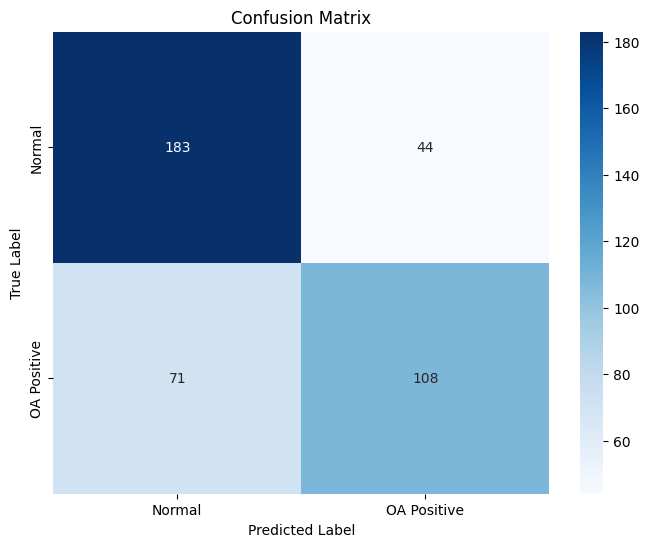

Test ROC AUC: 0.7597


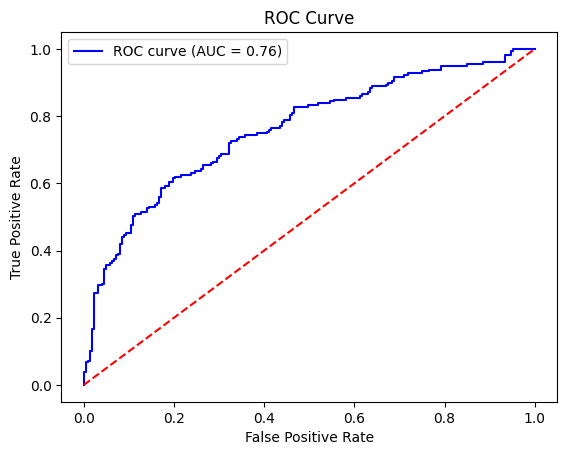

In [ ]:
seed = 42
os.environ['PYTHONHASHSEED'] = str(seed)
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)


# 1) 사전 학습된 모델 로드
pretrained_model = load_model("/content/drive/MyDrive/TMJ OA/학습_data_1,3(crop)/CBCT1,3_model555.keras")

# 모델 구조 확인
#pretrained_model.summary()

# 2) 데이터 로드 및 전처리
with open("/content/drive/MyDrive/TMJ OA/학습_data_2,4(crop)/tmj_oa_CBCT2,4_dataset_3.pkl","rb") as f:
    data_dict = pickle.load(f)

train_images = data_dict['train_data']['image']   # (N, 140, 140, 3) 가정
train_labels = data_dict['train_data']['label']  # (N,) 0/1
val_images   = data_dict['validation_data']['image']    # (M, 140, 140, 3)
val_labels   = data_dict['validation_data']['label']   # (M,) 0/1
test_images  = data_dict['test_data']['image']   # (K, 140, 140, 3)
test_labels  = data_dict['test_data']['label']  # (K,) 0/1

# 간단히 /255 정규화 (필요하다면 다른 전처리)
train_images = train_images / 255.0
val_images   = val_images / 255.0
test_images  = test_images / 255.0

# 3) Freeze 범위 & 학습 파라미터 설정
#    예: 모델이 Sequential 구조일 때, 맨 뒤 5개 레이어만 학습하고, 나머지 모두 Freeze
#    만약 Functional API 구조이면, 특정 레이어 이름을 기준으로 Freezing할 수 있음.
def freeze_until(model, until_layer_index=None):
    """
    model.layers를 순회하면서 until_layer_index 이전 레이어들은 trainable=False,
    이후 레이어들은 trainable=True.
    """
    if until_layer_index is None:
        # 전체 Freeze 해제 (모두 Trainable)
        for layer in model.layers:
            layer.trainable = True
    else:
        for i, layer in enumerate(model.layers):
            if i < until_layer_index:
                layer.trainable = False
            else:
                layer.trainable = True

# 여기서는, 예를 들어 "뒤쪽 5개 레이어"만 학습
# model.summary()로 레이어 목록을 보고 인덱스 조절
unfreeze_from_index = len(pretrained_model.layers) - 5
freeze_until(pretrained_model, None) #unfreeze_from_index

# optimizer, LR 등 하이퍼파라미터
learning_rate = 1e-4
pretrained_model.compile(
    optimizer=Adam(learning_rate=learning_rate),
    loss="binary_crossentropy",
    metrics=["accuracy", AUC(name="auc")]
)

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_labels),
    y=train_labels
)

#class_weights_dict = dict(enumerate(class_weights))
class_weights_dict = {0: 1, 1: 1.5}  # 클래스 1에 더 높은 가중치 부여
print("Class Weights:", class_weights_dict)


# 콜백 설정
early_stopping = EarlyStopping(monitor='val_auc', patience=10, mode='max', restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model_vgg16_auroc.keras', save_best_only=True, monitor='val_auc', mode='max')
reduce_lr = ReduceLROnPlateau(monitor='val_auc', factor=0.5, patience=7, mode='max', min_lr=1e-6)

# 4) Fine Tuning (훈련)
EPOCHS = 20
BATCH_SIZE = 32

history = pretrained_model.fit(
    x=train_images,
    y=train_labels,
    validation_data=(val_images, val_labels),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    shuffle=True,
    class_weight=class_weights_dict,
    callbacks=[early_stopping, model_checkpoint, reduce_lr]
)

# 5) 결과 평가 - Test set을 통해 AUROC, 혼동행렬, ROC 곡선 시각화
pred_probs = pretrained_model.predict(test_images)
# pred_probs.shape -> (K, 1), 이진분류 시 sigmoid 확률
pred_labels = (pred_probs > 0.5).astype(int).flatten()

# 5-1) Accuracy, Confusion Matrix, Classification Report
acc = np.mean(pred_labels == test_labels)
print("Test Accuracy:", acc)

report = classification_report(test_labels, pred_labels, target_names=["Class0","Class1"])
print("Classification Report:\n", report)

# Test 데이터에 대한 예측
y_pred_probs = pretrained_model.predict(test_images).flatten()  # Test 데이터 예측 확률
optimal_threshold = 0.5  # 임계값 설정
y_pred_adjusted = (y_pred_probs >= optimal_threshold).astype(int)  # 임계값 적용하여 클래스 예측

# 혼동행렬 생성
conf_matrix = confusion_matrix(test_labels, y_pred_adjusted)

# 혼동행렬 시각화
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Normal", "OA Positive"],
            yticklabels=["Normal", "OA Positive"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# 5-2) ROC Curve & AUC
fpr, tpr, thresholds = roc_curve(test_labels, pred_probs)
roc_auc = auc(fpr, tpr)
print(f"Test ROC AUC: {roc_auc:.4f}")

# 시각화
plt.figure()
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

CBCT Ensemble

In [ ]:
# 전체 병합

# CBCT와 MRI 피클 파일 로드
import pickle
import numpy as np

with open('/content/drive/MyDrive/TMJ OA/학습_data_1,3(crop)/tmj_oa_CBCT1,3_dataset555.pkl', 'rb') as f:
    cbct_data = pickle.load(f)

with open('/content/drive/MyDrive/TMJ OA/학습_data_2,4(crop)/tmj_oa_CBCT2,4_dataset_3.pkl', 'rb') as f:
    mri_data = pickle.load(f)

# 공통 환자 ID 추출
cbct_patient_ids = set(cbct_data['train_data']['patient_id'])
mri_patient_ids = set(mri_data['train_data']['patient_id'])
common_patient_ids = cbct_patient_ids.intersection(mri_patient_ids)
print(f"공통 환자 수: {len(common_patient_ids)}")

# 공통 환자의 데이터를 필터링하는 함수
def filter_common_data(data, common_ids, stage):
    filtered_data = {'image': [], 'label': [], 'patient_id': [], 'side': []}
    for i, pid in enumerate(data[stage]['patient_id']):
        if pid in common_ids:
            filtered_data['image'].append(data[stage]['image'][i])
            filtered_data['label'].append(data[stage]['label'][i])
            filtered_data['patient_id'].append(pid)
            filtered_data['side'].append(data[stage]['side'][i])
    return filtered_data

# Train, Validation, Test 데이터 필터링 및 병합
combined_data = {}
for stage in ['train_data', 'validation_data', 'test_data']:
    filtered_cbct = filter_common_data(cbct_data, common_patient_ids, stage)
    filtered_mri = filter_common_data(mri_data, common_patient_ids, stage)

    combined_data[stage] = {
        'CBCT_image': np.array(filtered_cbct['image']),
        'MRI_image': np.array(filtered_mri['image']),
        'label': np.array(filtered_cbct['label']),
        'patient_id': np.array(filtered_cbct['patient_id']),
        'side': np.array(filtered_cbct['side'])
    }

# 병합된 데이터 저장
with open('/content/drive/MyDrive/TMJ OA/CBCT1,3_CBCT2,4_combined_full555.pkl', 'wb') as f:
    pickle.dump(combined_data, f)

print("CBCT와 MRI 데이터 병합 완료. Train/Validation/Test 포함된 데이터 저장됨: CBCT_MRI_combined_full.pkl")


공통 환자 수: 789
CBCT와 MRI 데이터 병합 완료. Train/Validation/Test 포함된 데이터 저장됨: CBCT_MRI_combined_full.pkl


Train Data: CBCT=(1145, 140, 140, 3), MRI=(1145, 140, 140, 3), Labels=(1145,)
Validation Data: CBCT=(221, 140, 140, 3), MRI=(221, 140, 140, 3), Labels=(221,)
Test Data: CBCT=(207, 140, 140, 3), MRI=(207, 140, 140, 3), Labels=(207,)


7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 219ms/step


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step

Test 데이터 평가:
Ensemble Model AUC: 0.8372
Optimal Threshold: 0.1560

Confusion Matrix:
[[84 32]
 [14 77]]

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.72      0.79       116
           1       0.71      0.85      0.77        91

    accuracy                           0.78       207
   macro avg       0.78      0.79      0.78       207
weighted avg       0.79      0.78      0.78       207

Accuracy: 0.7778


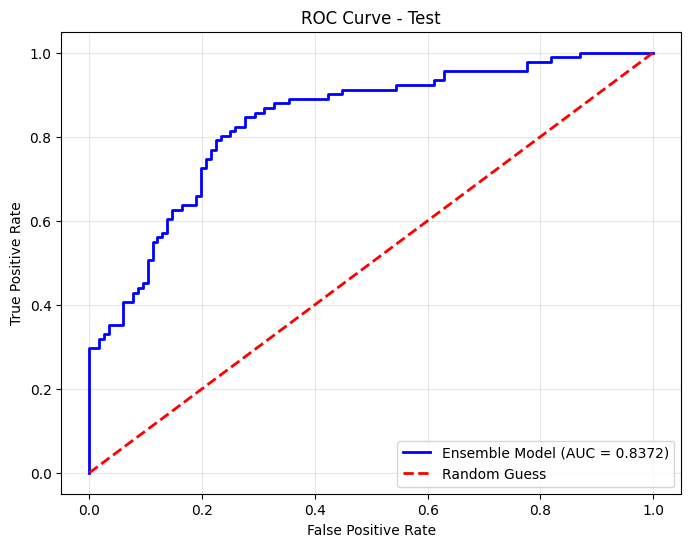

In [ ]:
# 1. 병합된 데이터 로드
with open('/content/drive/MyDrive/TMJ OA/CBCT1,3_CBCT2,4_combined_full555.pkl', 'rb') as f:
    combined_data = pickle.load(f)

# 데이터 준비 함수: CBCT와 MRI 데이터를 공통 환자에 대해서만 가져옴
def prepare_common_data(stage, combined_data):
    cbct_images = combined_data[stage]['CBCT_image']
    mri_images = combined_data[stage]['MRI_image']
    labels = combined_data[stage]['label']

    # 데이터 일관성을 맞추기 위해 공통 길이로 맞춤
    min_samples = min(len(cbct_images), len(mri_images), len(labels))
    return cbct_images[:min_samples] / 255.0, mri_images[:min_samples] / 255.0, labels[:min_samples]

# Train, Validation, Test 데이터 준비
cbct_train, mri_train, train_labels = prepare_common_data('train_data', combined_data)
cbct_val, mri_val, val_labels = prepare_common_data('validation_data', combined_data)
cbct_test, mri_test, test_labels = prepare_common_data('test_data', combined_data)

print(f"Train Data: CBCT={cbct_train.shape}, MRI={mri_train.shape}, Labels={train_labels.shape}")
print(f"Validation Data: CBCT={cbct_val.shape}, MRI={mri_val.shape}, Labels={val_labels.shape}")
print(f"Test Data: CBCT={cbct_test.shape}, MRI={mri_test.shape}, Labels={test_labels.shape}")

# 2. 기존 모델 불러오기
cbct_model = load_model('/content/drive/MyDrive/TMJ OA/학습_data_1,3(crop)/CBCT1,3_model555.keras')
mri_model = load_model('/content/drive/MyDrive/TMJ OA/학습_data_2,4(crop)/CBCT2,4_model.keras')

# 3. 예측 및 평가 함수
def evaluate_ensemble(cbct_model, mri_model, cbct_images, mri_images, labels, stage):
    # 모델 예측
    cbct_preds = cbct_model.predict(cbct_images).flatten()
    mri_preds = mri_model.predict(mri_images).flatten()
    ensemble_preds = (cbct_preds + mri_preds) / 2.0  # 앙상블 예측값

    # ROC Curve 및 AUC 계산
    fpr, tpr, thresholds = roc_curve(labels, ensemble_preds)
    ensemble_auc = auc(fpr, tpr)
    optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold = thresholds[optimal_idx]

    # 최종 예측
    final_preds = (ensemble_preds >= optimal_threshold).astype(int)

    # 성능 평가
    accuracy = accuracy_score(labels, final_preds)
    conf_matrix = confusion_matrix(labels, final_preds)
    class_report = classification_report(labels, final_preds)

    # 결과 출력
    print(f"\n{stage} 데이터 평가:")
    print(f"Ensemble Model AUC: {ensemble_auc:.4f}")
    print(f"Optimal Threshold: {optimal_threshold:.4f}")
    print("\nConfusion Matrix:")
    print(conf_matrix)
    print("\nClassification Report:")
    print(class_report)
    print(f"Accuracy: {accuracy:.4f}")

    # ROC Curve 시각화
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', lw=2, label=f"Ensemble Model (AUC = {ensemble_auc:.4f})")
    plt.plot([0, 1], [0, 1], color='red', linestyle='--', lw=2, label="Random Guess")
    plt.title(f"ROC Curve - {stage}")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend(loc="lower right")
    plt.grid(alpha=0.3)
    plt.show()

# 4. Train, Validation, Test 데이터 평가
#evaluate_ensemble(cbct_model, mri_model, cbct_train, mri_train, train_labels, "Train")
#evaluate_ensemble(cbct_model, mri_model, cbct_val, mri_val, val_labels, "Validation")
evaluate_ensemble(cbct_model, mri_model, cbct_test, mri_test, test_labels, "Test")